In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import cm

import random
from math import sin, cos, sqrt, atan2, radians
from ease_grid import EASE2_grid
grid_size = 36000
egrid = EASE2_grid(grid_size)
import time
from impacts import distance, IMPAaCS

In [2]:
# Set the size bins
max_diameter=330
# diam_bins = [5, 10, 50, 100]
# diam_labs = ['005', '005-009', '010-050', '050-100', '100+']
# diam_range = {'005':[1,5],'005-009':[5,9],'010-050':[10,50],'050-100':[50,100],'100+':[100,max_diameter]}
# lambda_start = {'005':1,'005-009':1.1,'010-050':1.2,'050-100':1.4,'100+':1.8}
# lambda_end = {'005':2,'005-009':4,'010-050':8,'050-100':16,'100+':32}

# diam_bins = [10, 50, 100]
# diam_labs = ['005-009', '010-050', '050-100', '100+']
# diam_range = {'005-009':[5,9],'010-050':[10,50],'050-100':[50,100],'100+':[100,max_diameter]}
# lambda_start = {'005-009':1.2,'010-050':1.2,'050-100':1.3,'100+':1.4}
# lambda_end = {'005-009':4,'010-050':6,'050-100':7,'100+':9}

# diam_bins = [50, 100]
# diam_labs = ['010-050', '050-100', '100+']
# diam_range = {'010-050':[10,50],'050-100':[50,100],'100+':[100,max_diameter]}
# lambda_start = {'010-050':1.2,'050-100':1.3,'100+':1.4}
# lambda_end = {'010-050':6,'050-100':7,'100+':9}

diam_bins = [20, 30, 40, 50, 100]
diam_labs = ['010-020',         '020-030',        '030-040',        '040-050',        '050-100',         '100+']
diam_range = {'010-020':[10,20],'020-030':[20,30],'030-040':[30,40],'040-050':[40,50],'050-100':[50,100],'100+':[100, max_diameter]}
lambda_start = {'010-020':1.1,  '020-030':1.2,    '030-040':1.3,    '040-050':1.4,    '050-100':1.5,     '100+':1.6}
lambda_end = {'010-020':4,      '020-030':7,      '030-040':10,      '040-050':13,      '050-100':16,       '100+':19}


In [3]:
# Make dictionary with size bins and frequency
with open('sfd.csv', 'r') as f:
    freqs = pd.read_csv(f).groupby('D').sum()
los_dict = {i:0 for i in diam_labs}
his_dict = {i:0 for i in diam_labs}
for i in freqs.index.values:
    for j in range(len(diam_bins)):
        if i < diam_bins[j] and i > 9:
            los_dict[diam_labs[j]] += freqs.loc[i,'low']
            his_dict[diam_labs[j]] += freqs.loc[i,'high']
            break
        elif i >= diam_bins[-1]:
            los_dict[diam_labs[-1]] += freqs.loc[i,'low']
            his_dict[diam_labs[-1]] += freqs.loc[i,'high']
            break
df_freq = pd.DataFrame.from_dict({'high':his_dict, 'low':los_dict, 
                                  'lambda_start':lambda_start, 'lambda_end':lambda_end})
#df_freq['frequency_factor'] = [0.1,0.2,0.3,0.6,0.8]
#df_freq['frequency_factor'] = [0.2,0.3,0.6,0.8]
#df_freq['frequency_factor'] = [0.3,0.6,0.8]
df_freq['frequency_factor'] = [0.1,0.2,0.3,0.5,0.6,0.7]
df_freq

,high,low,lambda_start,lambda_end,frequency_factor
010-020,120000,12000,1.1,4,0.1
020-030,18000,1800,1.2,7,0.2
030-040,5000,500,1.3,10,0.3
040-050,3100,310,1.4,13,0.5
050-100,8700,870,1.5,16,0.6
100+,3050,305,1.6,19,0.7


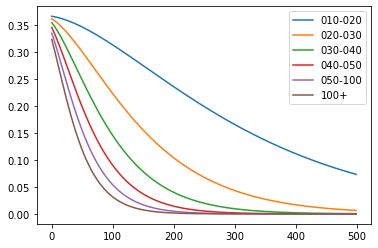

total impacts 24830.0
impacts by diameter {'010-020': 14028.0, '020-030': 4347.0, '030-040': 1143.0, '040-050': 419.0, '050-100': 2032.0, '100+': 2861.0}
fraction of total {'010-020': 0.56, '020-030': 0.18, '030-040': 0.05, '040-050': 0.02, '050-100': 0.08, '100+': 0.12}


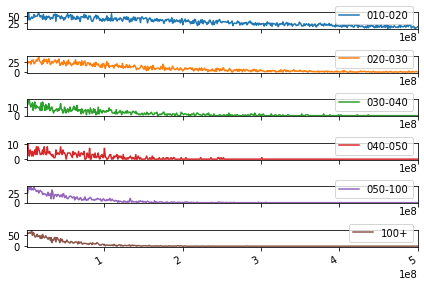

,high,low,lambda_start,lambda_end,frequency_factor,total
010-020,120000,12000,1.1,4,0.007437,14028.0
020-030,18000,1800,1.2,7,0.013234,4347.0
030-040,5000,500,1.3,10,0.031319,1143.0
040-050,3100,310,1.4,13,0.061342,419.0
050-100,8700,870,1.5,16,0.009550,2032.0
100+,3050,305,1.6,19,0.005244,2861.0


In [4]:
t_total=500

fivehundredmillion = 500000000
freq_factor = fivehundredmillion/t_total

not_converged=True
while not_converged:

    pp = {x:np.zeros(t_total) for x in diam_labs}
    l = {x:np.linspace(y,z,t_total) for x,y,z in zip(diam_labs,df_freq['lambda_start'],df_freq['lambda_end'])}

    for D in diam_labs:
        pp[D] = l[D]*np.exp(-l[D])

    df = pd.DataFrame(data=pp)
    hits = {d:np.zeros(t_total) for d in diam_labs}

    # Main loop through time. Calculate the total number of impacts of each diameter at each time step
    for t in range(0,t_total):
        for D in diam_labs:
            hits[D][t] = np.floor(np.random.poisson(pp[D][t] / df_freq.loc[D, 'frequency_factor']))


    total_sum = np.sum([hits[d] for d in diam_labs])
    sums = {d:np.sum(hits[d]) for d in diam_labs}
    frac = {d:np.round(np.sum(hits[d])/total_sum,2) for d in diam_labs}
    
    for d in diam_labs:
        df_freq.loc[d,'total']=sums[d]
    
    good_numbers = 0
    for d in diam_labs:
        if df_freq.loc[d,'total'] < df_freq.loc[d,'low']:
            df_freq.loc[d,'frequency_factor'] = df_freq.loc[d,'frequency_factor']*random.random()
        elif df_freq.loc[d,'total'] > df_freq.loc[d,'high']:
            df_freq.loc[d,'frequency_factor'] = df_freq.loc[d,'frequency_factor']*(1+random.random())
        else:
            good_numbers+=1
    if good_numbers == df_freq.shape[0]:
        not_converged = False
    
    
    
plt.plot(df)
plt.legend(df.columns.values)
plt.show()
print('total impacts', total_sum)
print('impacts by diameter', sums)
print('fraction of total', frac)
plot_time = np.linspace(0,fivehundredmillion,t_total+1)[1:]
df = pd.DataFrame(data=hits, index=plot_time)
df.plot(subplots=True)
plt.tight_layout()
plt.show()
df_freq

In [5]:
list_impacts_export = list(range(0,500,50))
list_impacts_export.append(499)

plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


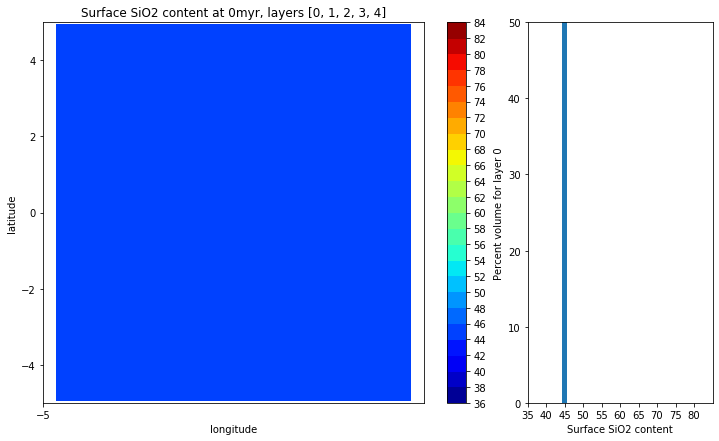

plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


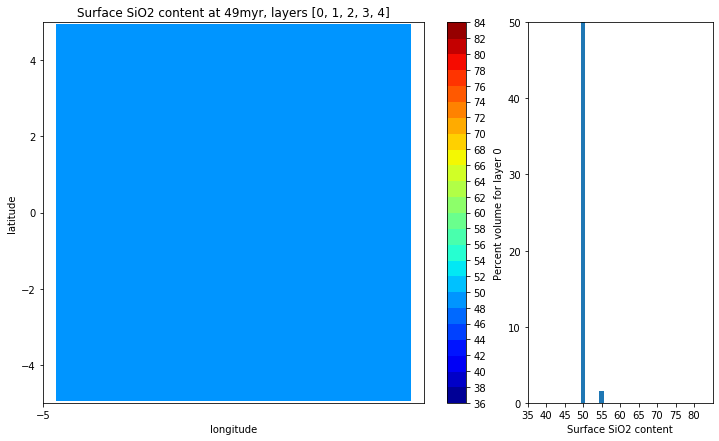

plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


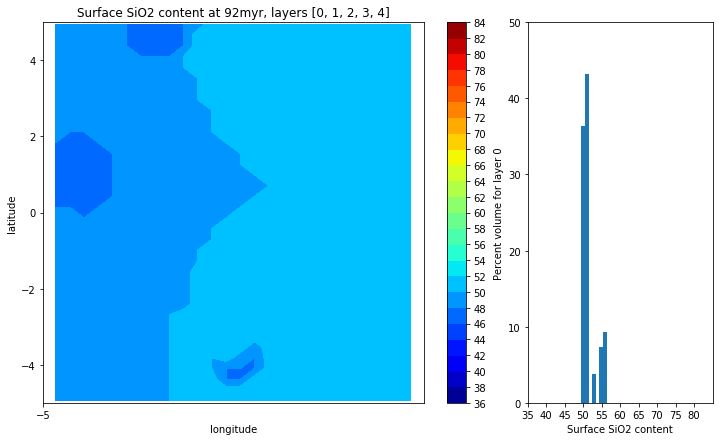

plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


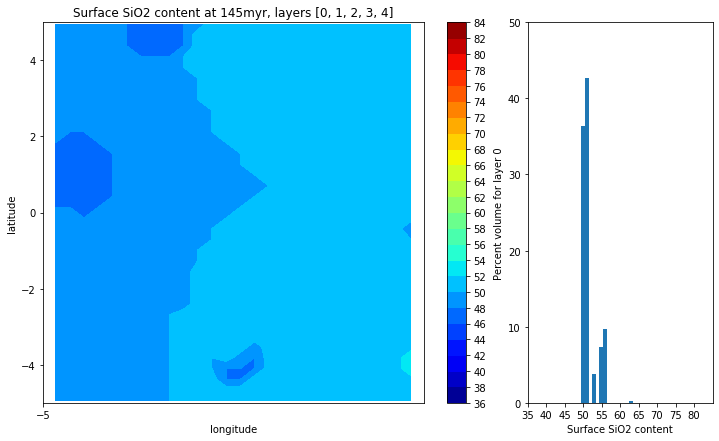

plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


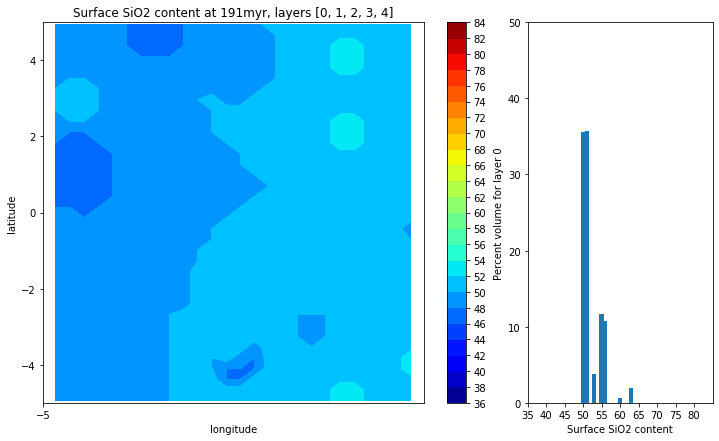

plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


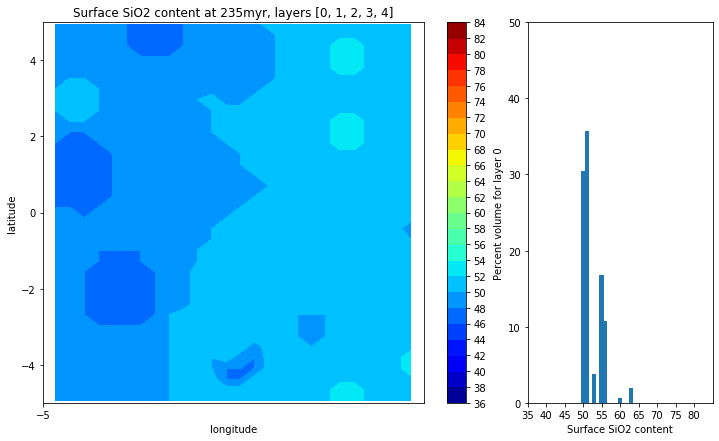

plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


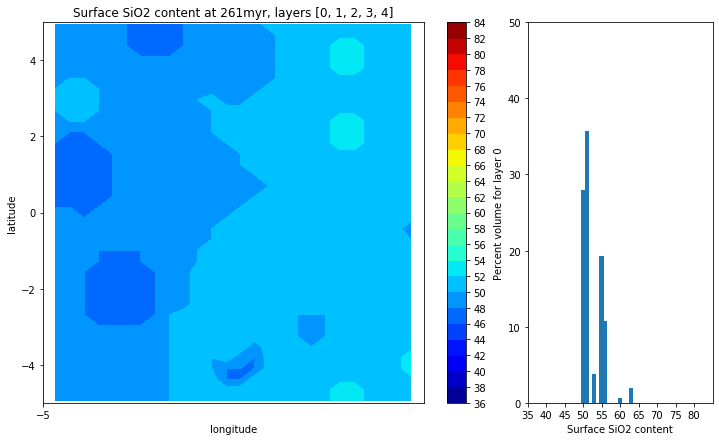

plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


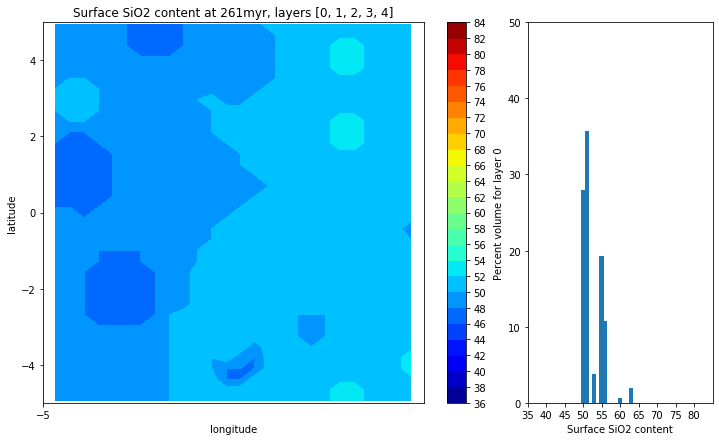

plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


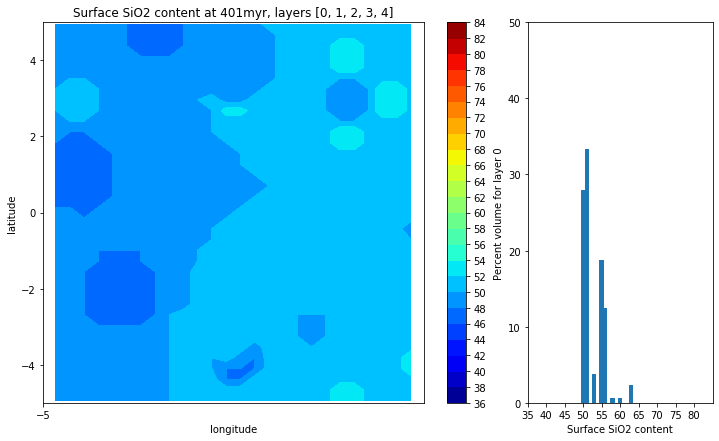

plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


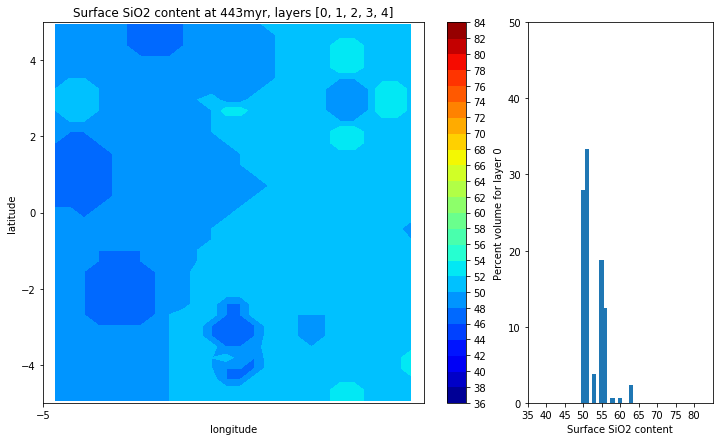

plotting SiO2  map for layers [0, 1, 2, 3, 4], and distribution for layer 0


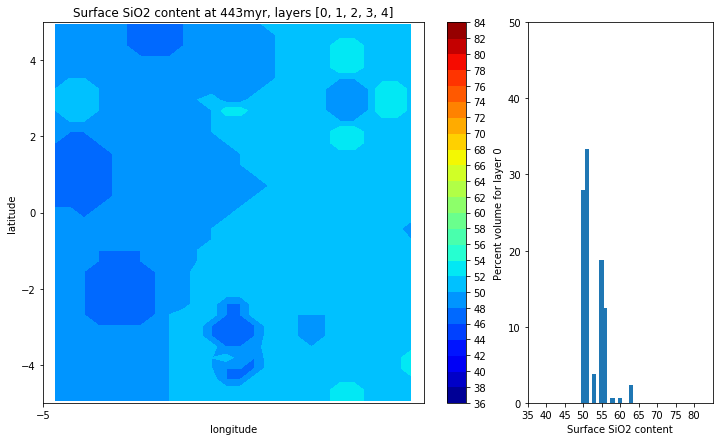

In [6]:
impact_boundz=5
[-impact_boundz, impact_boundz]
Impc = IMPAaCS(egrid, max_depth_of_impact_melt=330, 
               lon_lims = [-impact_boundz, impact_boundz], lat_lims = [-impact_boundz, impact_boundz],
               bound_sio2=True)

# Track the total volume of continental crust.
volume_crust = {i:0 for i in range(10)}
n_cubes_above_60_list = []

# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    start_time = time.time()
    for d in diam_labs:
        for i in range(int(df.loc[t,d])):
            
            impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
#             if impactor_diameter > 99.9:
#                 print(t, impactor_diameter)
            
            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            if np.abs(impact_lat) > impact_boundz:
                continue
            if np.abs(impact_lon) > impact_boundz:
                continue
            impact_loc = [impact_lat, impact_lon]
                
            #####      DO THE DYANMICS       #############################
            Impc.update(impact_loc, impactor_diameter, t)
            
    #layer_perc_vol = 0
    Impc.do_volume_by_layer(10) # The defauld n_layers is 1, so acting on layer 0

    count_cubes=True
    if count_cubes:
        n_cubes_above_60 = 0
        for i in range(10):
    #         print(Impc.sum_at_sio2_by_layer[i])
            for sio2_bin in list(Impc.sum_at_sio2_by_layer[i].keys()):
                if sio2_bin >= 60:
                    n_cubes_above_60 += Impc.sum_at_sio2_by_layer[i][sio2_bin]
        n_cubes_above_60_list.append(n_cubes_above_60)

    if it == 0:
        percent_df = pd.DataFrame(Impc.percent_volume_by_layer[0], index=[it])
    else:
        percent_df = percent_df.append(Impc.percent_volume_by_layer[0], ignore_index=True)
            
    # make a map of the results at this time
    if it in list_impacts_export:
        Impc.plot_map_and_bar(plot_figure=True, save_figure=False,
                              map_layers=[0,1,2,3,4], dist_layer=0)
#        print(percent_df.iloc[-1,:])

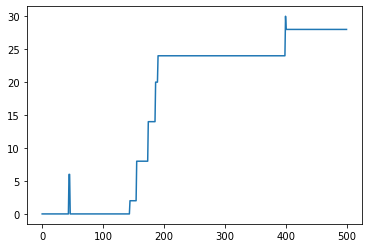

In [7]:
plt.plot(n_cubes_above_60_list)

In [ ]:
impact_boundz=20
[-impact_boundz, impact_boundz]
Impc = IMPAaCS(egrid, max_depth_of_impact_melt=330, 
               lon_lims = [-impact_boundz, impact_boundz], lat_lims = [-impact_boundz, impact_boundz])
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    start_time = time.time()
    for d in diam_labs:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            if np.abs(impact_lat) > impact_boundz:
                continue
            if np.abs(impact_lon) > impact_boundz:
                continue
            impact_loc = [impact_lat, impact_lon]
            impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            Impc.update(impact_loc, impactor_diameter, t)
            
    Impc.do_sample_percents(n_layers=2)
    
    if it == 0:
        percent_df = pd.DataFrame(Impc.sample_percents, index=[it])
    else:
        percent_df = percent_df.append(Impc.sample_percents, ignore_index=True)
            
    # make a map of the results at this time
    if it in list_impacts_export:
        Impc.plot_map_and_bar(plot_figure=True)
        print(percent_df.iloc[-1,:])

In [ ]:
plt.plot(Impc.test_time, Impc.average_test_target_list)
plt.plot(Impc.test_time, Impc.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(Impc.test_time, Impc.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()

In [ ]:
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
print("This is only a test. I am forcing impacts at one location to test the dynamics")
print("This is only a test. I am forcing impacts at one location to test the dynamics")
I = IMPAaCS(egrid)
I.__init__(egrid)
impact_test_diameters = [330, 73, 16, 10, 5, 2, 330, 73, 16, 10, 5, 2]
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    print('time', it)
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            impact_loc = [impact_lat, impact_lon]

            # Specify the diameter within the bin
            if it < len(impact_test_diameters):                  # Test scenario
                impactor_diameter = impact_test_diameters[it]    # Test scenario
                impact_lat = 0.18672199                             # Test scenario
                impact_lon = 0.14122179                            # Test scenario
                impact_loc = [impact_lat, impact_lon]            # Test scenario
            else:                                                # Test scenario
                impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            I.update(impact_loc, impactor_diameter, t)

            break  # Test scenario

        if it < len(impact_test_diameters):   # Test scenario
            print("This is only a test. I am forcing impacts at one location to test the dynamics")
            print('{} diameter IMPAaC at Test cell: {}'.format(impactor_diameter, 
                                                               I.impact_test_id))
            print('average_target: {}, across {} grid cells'.format(np.round(I.average_target,1), 
                                                            len(I.impacted_grid_cells)))
            print("SiO2 states:")
            print(list(I.grid_cell_state[I.impact_test_id])[0:75])
            print(" ")
        break  # Test scenario

    if it > len(impact_test_diameters):  # Test scenario
        break  # Test scenario

In [ ]:
plt.plot(I.test_time, I.average_test_target_list)
plt.plot(I.test_time, I.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(I.test_time, I.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()

# 10 X impacts teste cast

In [ ]:
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
### This is only a test. I am forcing impacts at one location to test the dynamics
print("This is only a test. I am forcing impacts at one location to test the dynamics")
print("This is only a test. I am forcing impacts at one location to test the dynamics")
I = IMPAaCS(egrid, bound_sio2=True)
I.__init__(egrid)
impact_test_diameters = [330, 330, 330, 330, 330, 330, 330, 330, 330, 330,
                         73, 73, 73, 73, 73, 73, 73, 73, 73, 73,
                         16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 
                         10, 10,  10,  10,  10,  10,  10,  10,  10,  10, 
                         5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                         2, 2, 2, 2, 2, 2, 2, 2, 2, 2,]
# Loop through impacts, the df has them stored by time and diameter bn
for it, t in enumerate(df.index.values):
    print('time', it)
    for d in diam_labs[3:]:
        for i in range(int(df.loc[t,d])):

            # locate the the impacts on earth
            impact_lat = random.randrange(-90,90)
            impact_lon = random.randrange(-180,180)
            impact_loc = [impact_lat, impact_lon]

            # Specify the diameter within the bin
            if it < len(impact_test_diameters):                  # Test scenario
                impactor_diameter = impact_test_diameters[it]    # Test scenario
                impact_lat = 0.18672199                             # Test scenario
                impact_lon = 0.14122179                            # Test scenario
                impact_loc = [impact_lat, impact_lon]            # Test scenario
            else:                                                # Test scenario
                impactor_diameter = random.randrange(diam_range[d][0],diam_range[d][1])
                
            #####      DO THE DYANMICS       #############################
            I.update(impact_loc, impactor_diameter, t)

            break  # Test scenario

        if it < len(impact_test_diameters):   # Test scenario
            print("This is only a test. I am forcing impacts at one location to test the dynamics")
            print('{} diameter IMPAaC at Test cell: {}'.format(impactor_diameter, 
                                                               I.impact_test_id))
            print('average_target: {}, across {} grid cells'.format(np.round(I.average_target,1), 
                                                            len(I.impacted_grid_cells)))
            print("SiO2 states:")
            print(list(I.grid_cell_state[I.impact_test_id])[0:75])
            print(" ")
        break  # Test scenario

    if it > len(impact_test_diameters):  # Test scenario
        break  # Test scenario

In [ ]:
plt.plot(I.test_time, I.average_test_target_list)
plt.plot(I.test_time, I.top_layer_at_test_cell)
plt.legend(["average target", "top layer, single cell"])
plt.xlabel("time")
plt.ylabel("SiO2")
plt.show()
plt.close()
plt.scatter(I.test_time, I.impactors_at_test_cell)
plt.ylabel("impact diameter")
plt.xlabel("time")
plt.show()
plt.close()